(chap_pixels)=
# Images & pixels

:::{admonition} Chapter outline
:class: tip

* Digital images are composed of **pixels**
* Each pixel has a **numeric value** (often related to detected light)
* The same pixel values can be displayed differently using **lookup tables (LUTs)**
* We can modify image appearance in two main ways:
  1. **Change the pixel values**
  2. **Change the LUT**
* **Preserving pixel values is crucial** for most analysis -- so it's essential to know what your software is doing
:::

In [1]:
"""
Nothing very interesting to see here:
these are just default imports that help the rest of the code on this page run.
"""

%load_ext autoreload
%autoreload 2

# Default imports
import sys
sys.path.append('../../../')
from helpers import *
from matplotlib import pyplot as plt
from myst_nb import glue
import numpy as np
from scipy import ndimage

## Introduction

Image are composed of **pixels**.

The word 'pixel' is derived from **pic**ture **el**ement and, as far as the computer is concerned, each pixel is just a number.

When the image data is displayed, the values of pixels are usually converted into squares of particular colors – but *this is only for our benefit*.
The colored squares are nothing more than a helpful visualization that enable us to gain a fast impression of the image contents, i.e. the approximate values of pixels and where they are in relation to one another.

When it comes to processing and analysis, we need to get past the display and delve into the real data: the numbers ({numref}`fig-image_array`).

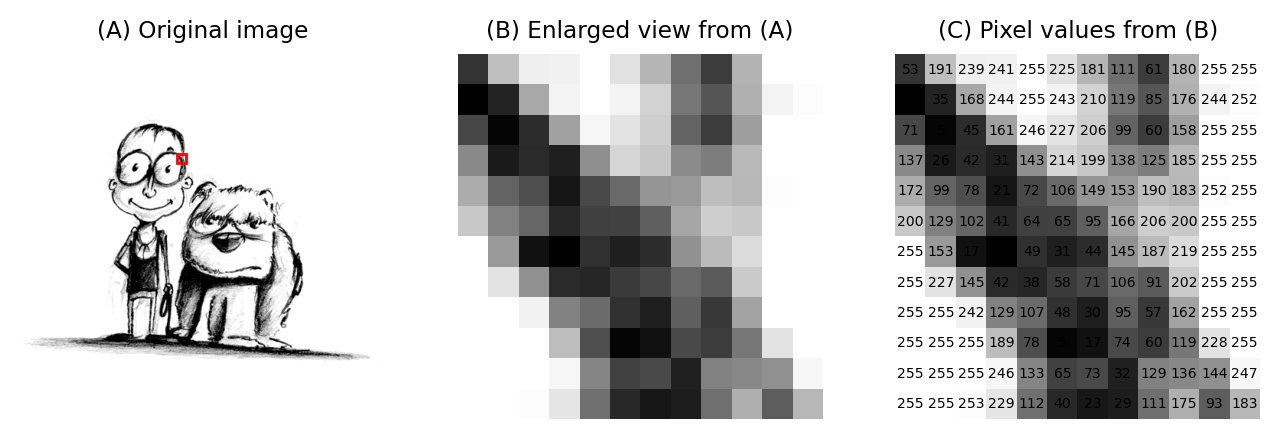

In [2]:
"""
Welcome! Here you can see the first example of Python code used to generate
figures in this book.

If you are working with a 'live' version of the book, you should be able to
make some adjustments to regenerate new figures.

Each code block contains two main parts:
1. A part responsible for loading images, applying processing etc.
2. A part that plots the result in a figure (usually with matplotlib)

The first of these is the most important, because it complements the main text.
My hope is that, by seeing the code involved, concepts might become clearer.

The plotting itself can be quite fiddly to make everything align, and can often
be ignored.

As a rule, I use the following conventions:
- A variable starting with 'im_' refers to a 'normal' image
- A variable starting with 'bw_' refers to a binary image
- A variable starting with 'lab_' refers to a labeled image

When it comes to plotting, 'fig' invariably refers to the figure being plotted
and 'plt' refers to 'pyplot' (standard in matplotlib).
'show_image', 'show_plot' and 'show_histogram' are helper methods to standardize
display throughout the book.
'glue' and 'glue_fig' other what enable the plots to be incorporating into the book.
"""


# Read an image & select a detailed region
im = load_image('images/couple.png')
x, y, width, height = (205, 130, 12, 12)
im_detail = im[y:y+height, x:x+width]


# Show plots
fig = create_figure(figsize=(8, 4))
import matplotlib.patches as patches
rect = patches.Rectangle((x, y), width, height, linewidth=1, edgecolor='r', facecolor='none')

show_image(im, vmin=0, vmax=255, title='(A) Original image', pos=131)
plt.gca().add_patch(rect)

show_image(im_detail, vmin=0, vmax=255, title='(B) Enlarged view from (A)', pos=132)

show_image(im_detail, vmin=0, vmax=255, alpha = 1, title='(C) Pixel values from (B)', pos=133)
for (i, j), z in np.ndenumerate(im_detail):
    plt.text(j, i, str(z), ha='center', va='center', fontdict={'size': 5})

glue_fig('fig_couple', fig)

```{glue:figure} fig_couple
:align: center
:name: fig-image_array
An image depicting an interestingly-matched couple I saw when walking home from work. (A) & (B) The image is shown using small squares of different shades of gray, where each square corresponds to a single pixel. This is only a convention used for display; the pixels themselves are stored as arrays of numbers \(C) -- but looking at the numbers directly it's pretty hard for us to visualize what the image contains.
```

## Image data & its display

The distinction between a pixel's numeric value and the color used to display it might seem like a minor detail, but it definitely isn't: failing to recognise this difference underlies a *lot* of errors.

If we aren't careful, two related facts can cause us an enormous amount of trouble:

:::{warning}
1.  Images that **look the same** can contain **different** pixel values
2.  Images that **look different** can still contain **the same** pixel values
:::

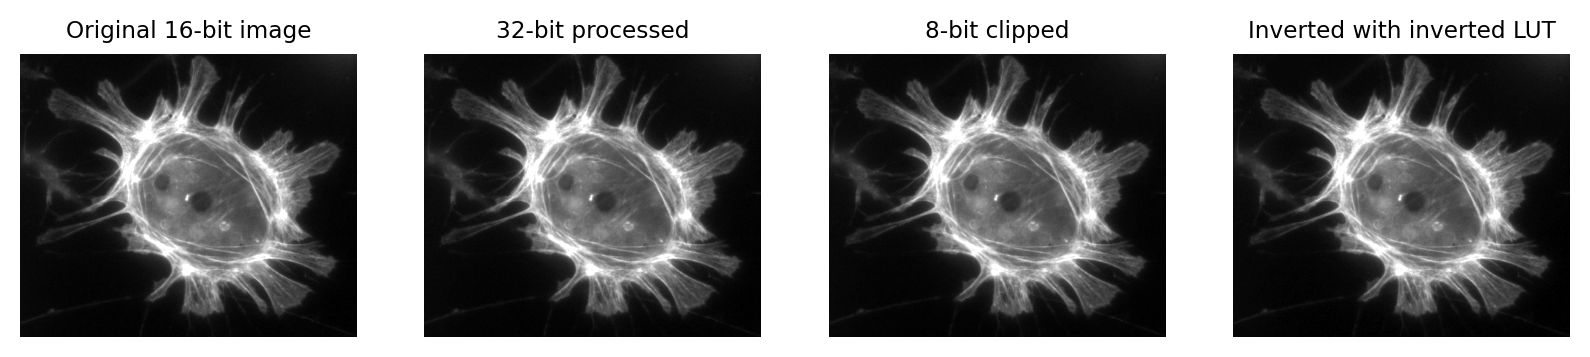

In [3]:
"""
Create four images that look exactly the same, but all contain different pixel values.
"""

im = load_image('sunny_cell.tif')
assert im.dtype == np.uint16
fig = create_figure(figsize=(10, 4))

# Original image, with 1% clipped for display
vmin = np.percentile(im, 1)
vmax = np.percentile(im, 99)
show_image(im, cmap='gray', title='Original 16-bit image', vmin=vmin, vmax=vmax, pos=141)

# 32-bit, rescaled
im2 = (im.astype(np.float32) - im.mean()) / im.std() * 50
vmin2 = np.percentile(im2, 1)
vmax2 = np.percentile(im2, 99)
show_image(im2, cmap='gray', title='32-bit processed', vmin=vmin2, vmax=vmax2, pos=142)

# 8-bit, clipped
im3 = im.astype(np.float32)
im3 = (im3 - vmin) / (vmax - vmin) * 255
im3 = np.clip(im3, 0, 255)
im3 = im3.astype(np.uint8)
show_image(im3, cmap='gray', title='8-bit clipped', vmin=0, vmax=255, pos=143)

# 8-bit, clipped, then inverted with inverted LUT
im4 = 255 - im3
show_image(im4, cmap='gray_r', title='Inverted with inverted LUT', vmin=0, vmax=255, pos=144)

glue_fig('fig_images_look_same', fig)

```{glue:figure} fig_images_look_same
:align: center
:name: fig-images_look_same
Images that *look* the same, but contain *different* pixel values.\
Measuring each of these images would give different results, for reasons we shall see in later chapters.
```

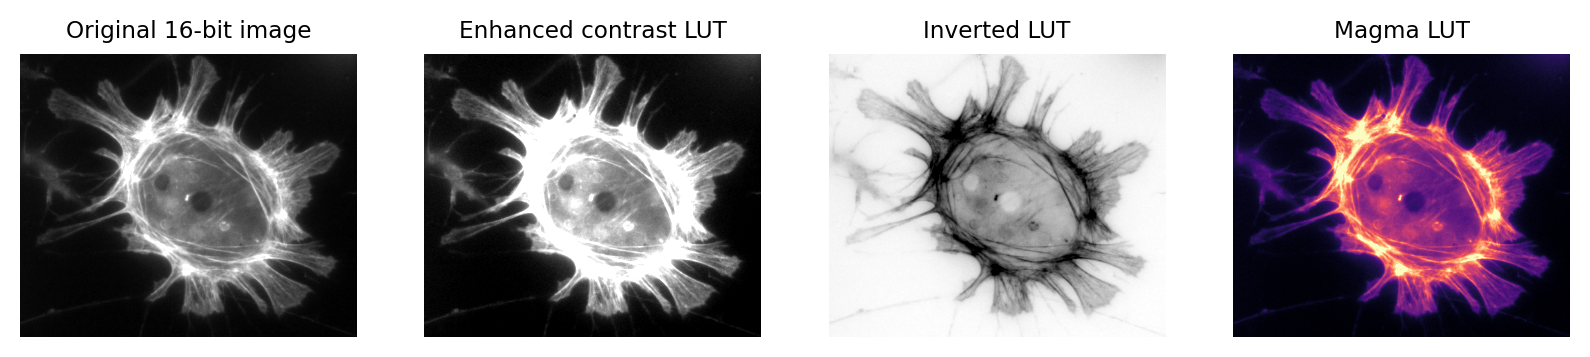

In [4]:
"""
Display the same image in 4 different ways by changing the LUT/colormap.
"""

im = load_image('sunny_cell.tif')
assert im.dtype == np.uint16
fig = create_figure(figsize=(10, 4))

# Original image, with 1% clipped for display
vmin = np.percentile(im, 1)
vmax = np.percentile(im, 99)
show_image(im, cmap='gray', title='Original 16-bit image', vmin=vmin, vmax=vmax, pos=141)

# Original image, with 10% clipped for display
vmin2 = np.percentile(im, 10)
vmax2 = np.percentile(im, 90)
show_image(im, cmap='gray', title='Enhanced contrast LUT', vmin=vmin2, vmax=vmax2, pos=142)

# Invert the LUT (in matplotlib, just add '_r' at the end)
show_image(im, cmap='gray_r', title='Inverted LUT', vmin=vmin, vmax=vmax, pos=143)

# Use an alternative LUT
show_image(im, cmap='magma', title='Magma LUT', vmin=vmin, vmax=vmax, pos=144)

glue_fig('fig_images_look_different', fig)

```{glue:figure} fig_images_look_different
:align: center
:name: fig-images_look_different
Images that *look* different, but contain *the same* pixel values.\
Measuring each of these images would give the same results.
```

This is crucial because it's entirely possible to analyze two different images that *appear* identical, but to get very different (and very wrong) results.

This is far from a theoretical problem.
It happens a lot in practice whenever someone innocently makes an adjustment to an image (e.g. to make it look brighter, or change the colors for display) without realising that the adjustment has actually changed the pixel values -- and thereby compromised the underlying data.
This can fatally undermine the integrity of any later analysis.

What's worse, these errors can go completely unnoticed, surreptitiously compounding the problem of replicability in science.

Which brings us to the key message of this chapter:

:::{admonition} Don't (just) trust your eyes!
:class: danger

In science, we need to know what is happening whenever we open, adjust and save our images.
If we don't, we risk misinterpreting our data.
:::

Fortunately, knowing just a little bit about imaging and image analysis is enough to avoid making these mistakes.
Knowing more than a little bit can open up new worlds of possibility to extract useful information from scientific images.

The goal of this handbook is to explain these ideas.
We'll start by considering two questions:

1. **Where do the pixel values come from?**
2. **How are pixel values converted into colors for display?**

It's hard to give a detailed-but-general answer to the first question, because the origin and interpretation of the pixel values depends upon how the image was created, and there are many different ways to generate an image.

Nevertheless, the key ideas are similar everywhere.
By way of illustration, we'll consider a very common case in bioimaging where the pixel values relate to detected light -- specifically, using the example of a fluorescence microscope -- before moving how to see how these values are displayed.

## A simple microscope

When I work with fluorescence images, I have a very simple picture in my head of how the image is formed.
It may not be very exact, but I find it extremely useful as a basis to which we can add detail whenever we need it.
We will revisit this picture later in the book to help organize the interrelating imaging considerations relevant to analysis.

In my simplified model, there are only three components that we need to worry about:

1. **Sample** -- the thing we want to look at
2. **Objective lens** -- the thing that gathers the light and focusses it for detection
3. **Detector** -- the thing that detects the light to form the digital image (here, a CCD camera)

The process is illustrated below:

<video autoplay loop playsinline controls muted>
  <source src="../../../_static/videos/simple_microscope.mp4" type="video/mp4">
</video>

There are a couple of things to note at this point:

* Not *all* the light emitted from the sample is detected. A lot of it never enters the objective lens.
* Our images aren't perfect. We will explore problems of blur, noise and pixel size later.

For now, we are mostly interested in the detection step and how it generates a digital image.
Zooming in to look at this in more detail, we can imagine what happens as light hits the camera.
The sensor of the camera itself is divided into **physical pixels**, which will correspond to the pixels in the final image.
When a photon strikes the detector, an electron may be released at one of the physical pixels.
During the acquisition of an image, many photons strike the detector, which can cause many electrons to be released at different physical pixels.
These electrons contribute to the value of a pixel in the final image: more electrons &rarr; higher pixel values.

<video autoplay loop playsinline controls muted>
  <source src="../../../_static/videos/simple_camera.mp4" type="video/mp4">
</video>

The important point is that **pixel values are only *indirectly* related to whatever it is in our sample that we want to measure**.

In this example, they have been derived by quantifying the charge of electron clouds gathered at each physical pixel.
This should be proportional to the amount of detected light that originated from a particular volume of the sample.
This, in turn, depends upon what is actually present in the sample -- but there are *a lot* of things that can influence the final values in connection with acquisition parameters, conversion factors, and physics.
These are not usually related directly to the thing you might want to quantify.

:::{admonition} Some of the factors influencing pixel values
:class: info
* **Amount of time spent detecting photons**
  * *More time → More photons → More electrons → Higher pixel values*
* **Numerical aperture of the objective lens**
  * This relates to the **angle** of light accepted by the objective
  * *Higher NA → Larger angle → More photons → More electrons → Higher pixel values*
* **Sensitivity of the detector (Quantum Efficiency)**
  * Not all photons necessarily produce an electron; I think of this as the photon hitting the detector, but not hard enough to dislodge an electron. A detector with low sensitivity is likely to 'miss' more photons, so that they never contribute to the pixel value.
  * *Higher sensitivity → More electrons → Higher pixel values*
:::

Ultimately, this leads to the warning:

:::{admonition} Don't over-interpret pixel values!
:class: danger

Individual pixel values are rarely very meaningful in isolation: we're usually interested in *relative* differences between groups of pixels.
:::

As we shall see, this means that we often need to average values and normalize to something whenever we want to make measurements in an image.
We can't usually untangle the influences well enough to infer anything with confidence from a single pixel value.

But the limitations in what pixel values can tell us don't diminish their importance: on the contrary, pixel values remain our raw data and it's essential that we preserve them as faithfully as possible.
That's a lot harder than you might expect.
It requires knowing when and how pixel values might become changed whenever we are working with our images.
This is so crucial that it will be the focus throughout the entire first part of this book.

(sec_images_luts)=
## Lookup tables

```{margin} LUTs vs. Colormaps
**Lookup tables** are sometimes referred to as **colormaps**.

For our purposes, the terms are interchangeable -- you may see either depending upon which software you are using.
```

So images are really comprised of a lot of numbers -- the pixel values -- even though we normally visualize them as shapes and colors.

It's time then to consider our second question: **How are pixel values converted for display?**

The basic idea is simple: the software displaying the image uses a **lookup table (LUT)** that maps each pixel value to a color.
When it comes to showing the image, each pixel is replaced by a little dot or square on screen that has the corresponding color.

<video autoplay loop playsinline controls muted>
  <source src="../../../_static/videos/luts_intro.mp4" type="video/mp4">
</video>

LUTs therefore provide a way to **change the appearance of an image without changing its pixel values**.

This is extremely useful in practice.
Since images in biology often have rather low pixel values (formed from a small amount of detected light), we very often want to change their brightness for display.

One way we *could* make an image brighter is to change the pixel values themselves -- multiply them by 2, for example.
That would indeed usually make the image look brighter, but we risk making a terrible mess of our data if we permit ourselves to make such changes.
As described above, we really don't want to modify our raw data unnecessarily.

A **much** better way to change the brightness of an image is to change the LUT only.

<video autoplay loop playsinline controls muted>
  <source src="../../../_static/videos/luts_brightness.mp4?raw=true" type="video/mp4">
</video>

The danger is that **not all software cares so much about preserving pixel values**.
Someone wanting to enhance their holiday photos isn't likely to care about retaining the original pixel values for quantification later; rather, they just want the images to look as nice as possible.

For this reason, a lot of software designed for working with images really *will* rescale the pixel values when you do something as simple as adjusting the brightness.
And so it is entirely possible to open an image, adjust the display slightly to see things more clearly, and in doing so irreparably damage the image -- losing the raw data required for later analysis.

This is why you should **use scientific software for scientific image analysis** -- and not just any general imaging editing software you might find.

But even when using scientific software, it's often possible to change pixel values whenever you'd really rather only be changing lookup tables.
The next chapter will show how to check when this is happening.